In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import tensorflow as tf
import os
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import warnings
warnings.filterwarnings('ignore')

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [3]:
data_dir = 'KnownData'


In [4]:
os.listdir(data_dir)

['normal', 'sick']

In [5]:
data = tf.keras.utils.image_dataset_from_directory('KnownData')

Found 715 files belonging to 2 classes.


In [6]:
image_exts = ['jpeg','jpg','png','bmp']

In [7]:
data_iterator = data.as_numpy_iterator()

In [8]:
batch = data_iterator.next()


In [9]:
#images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [12]:
#these represent the labels
batch[1]

array([1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 0])

In [13]:
scaled= batch[0]/255

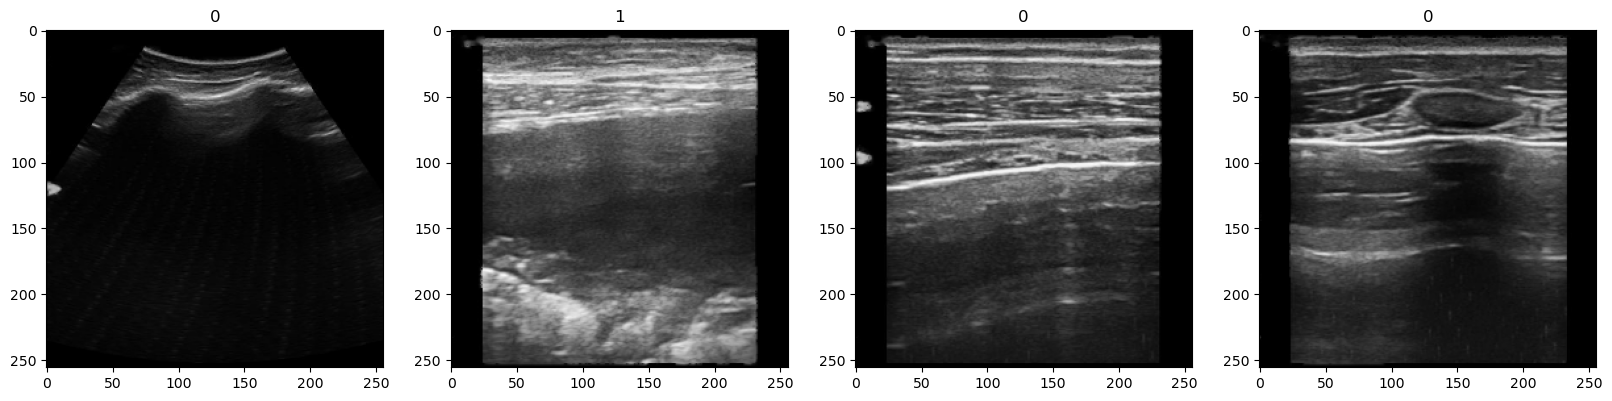

In [38]:
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [14]:
#scaling the data
data = data.map(lambda x, y: (x/255, y) )

In [15]:
data.as_numpy_iterator().next()[0].max()

0.994784

In [41]:
len(data)

23

In [42]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [43]:
train_size

16

In [44]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [45]:
model = Sequential()

In [46]:
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2))),
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [47]:
model.compile(optimizer='adam', loss= tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [49]:
logdir = "logs"

In [50]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [51]:
hist = model.fit(train ,epochs=20, validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/20
16/16 [==============================] - 60s 3s/step - loss: 0.5273 - accuracy: 0.7578 - val_loss: 0.3180 - val_accuracy: 0.8516
Epoch 2/20
16/16 [==============================] - 41s 2s/step - loss: 0.2193 - accuracy: 0.9082 - val_loss: 0.1604 - val_accuracy: 0.9375
Epoch 3/20
16/16 [==============================] - 40s 2s/step - loss: 0.1838 - accuracy: 0.9277 - val_loss: 0.1266 - val_accuracy: 0.9844
Epoch 4/20
16/16 [==============================] - 40s 2s/step - loss: 0.1585 - accuracy: 0.9297 - val_loss: 0.0893 - val_accuracy: 0.9766
Epoch 5/20
16/16 [==============================] - 40s 2s/step - loss: 0.0828 - accuracy: 0.9688 - val_loss: 0.0748 - val_accuracy: 0.9531
Epoch 6/20
16/16 [==============================] - 40s 2s/step - loss: 0.0417 - accuracy: 0.9883 - val_loss: 0.0715 - val_accuracy: 0.9609
Epoch 7/20
16/16 [==============================] - 36s 2s/step - loss: 0.0368 - accuracy: 0.9824 - val_loss: 0.0338 - val_accuracy: 0.9922
Epoch 8/20
16/16 [==

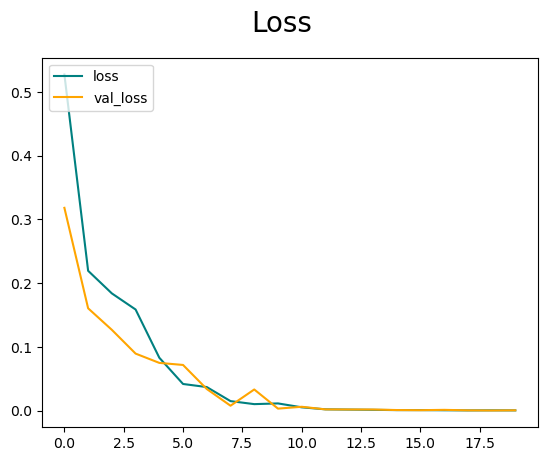

In [52]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

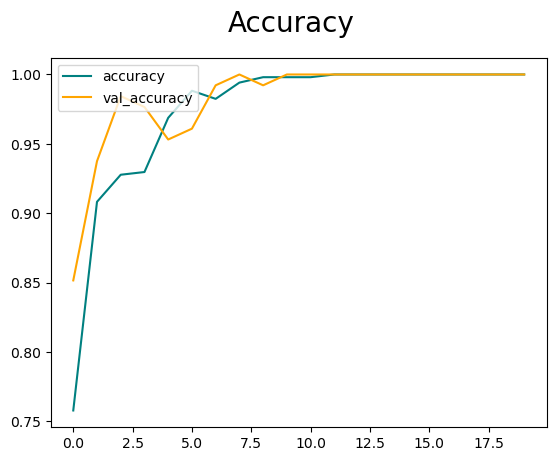

In [53]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [54]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [55]:
for batch in test.as_numpy_iterator():
    x,y = batch
    yhat = model.predict(x)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 [==============================] - 1s 512ms/step


In [58]:
print(f'Precision:{precision.result().numpy()}, Recall:{recall.result().numpy()}, Accuracy:{accuracy.result().numpy()})')

Precision:1.0, Recall:1.0, Accuracy:1.0)


In [59]:
# save the trained model as a .h5 file
model.save('models/chestOpacity_model_1.h5')

In [60]:
##Doing prediction for the unknown dataset

In [3]:
from tensorflow.keras.models import load_model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [22]:
model1 = load_model('models/chestOpacity_model_1.h5')
data_dir1 = 'dataset1/unknown_images'
image_files = os.listdir(data_dir1)
predicted_df = pd.DataFrame(columns=['Filename', 'Prediction', 'Predicted Class'])

for filename in image_files:
    # Load the image and preprocess it
    image = load_img(os.path.join(data_dir1, filename), target_size=(256, 256))
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)
    image_array = image_array / 255.0
    
    # Make the prediction
    prediction = model1.predict(image_array)[0][0]
    
    # Determine the predicted class based on the prediction threshold
    if prediction > 0.5:
        predicted_class = 'opacity'
    else:
        predicted_class = 'no_opacity'
    
    # Add the prediction to the DataFrame
    df_new_row = pd.DataFrame({'Filename': [filename], 'Prediction': [round(prediction, 2)], 'Predicted Class': [predicted_class]})
    predicted_df = pd.concat([predicted_df, df_new_row])
    
    # Print the predicted class
    print(f"Predicted class for '{filename}' is {predicted_class}")

# Save the predictions to a CSV file
predicted_df.to_csv('results/unknown_images_predictions_model_1.csv', index=False)



1/1 [==============================] - 0s 117ms/step
Predicted class for '1.png' is opacity
1/1 [==============================] - 0s 35ms/step
Predicted class for '10.png' is opacity
1/1 [==============================] - 0s 52ms/step
Predicted class for '11.png' is no_opacity
1/1 [==============================] - 0s 41ms/step
Predicted class for '12.png' is opacity
1/1 [==============================] - 0s 35ms/step
Predicted class for '13.png' is no_opacity
1/1 [==============================] - 0s 51ms/step
Predicted class for '14.png' is opacity
1/1 [==============================] - 0s 52ms/step
Predicted class for '15.png' is no_opacity
1/1 [==============================] - 0s 90ms/step
Predicted class for '16.png' is opacity
1/1 [==============================] - 0s 37ms/step
Predicted class for '17.png' is no_opacity
1/1 [==============================] - 0s 40ms/step
Predicted class for '18.png' is opacity
1/1 [==============================] - 0s 45ms/step
Predicted class 

In [37]:
##Doing prediction for dataset 2

In [36]:
model2 = load_model('models/chestOpacity_model_1.h5')

# Set the path to the folder containing the test images
test_folder = 'dataset2/images'

# Get the list of images in the test folder
test_filenames = os.listdir(test_folder)

# Loading the labels from the CSV file
labels_df = pd.read_csv('dataset2/image_classes.csv')

# Create empty lists to store the true and predicted labels
true_labels = []
predicted_labels = []

# Loop over each test image and make a prediction
for filename in test_filenames:
    # Load the image and preprocess it
    image = load_img(os.path.join(test_folder, filename), target_size=(256, 256))
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)
    image_array = image_array / 255.0

    # Make the prediction
    prediction = model2.predict(image_array)[0][0]
    predicted_label = int(round(prediction))

    # Get the filename without extension
    filename_no_extension = os.path.splitext(filename)[0]

    # Find the row in labels_df with the matching filename
    matching_row = labels_df.loc[labels_df['patient '] == filename_no_extension]


    # Check if a matching row was found
    if not matching_row.empty:
        # Get the true label from the matching row
        true_label = matching_row['diagnosis (0-Normal, 1-Sick)'].values[0]

        # Append the true and predicted labels to the lists
        true_labels.append(true_label)
        predicted_labels.append(predicted_label)

# Create a DataFrame to store the results
results_df = pd.DataFrame({'Filename': test_filenames, 'True Label': true_labels, 'Predicted Label': predicted_labels})

# Save the results to a CSV file
results_df.to_csv('results/test_results.csv', index=False)


1/1 [==============================] - 0s 97ms/step


In [35]:
print(labels_df.columns)

Index(['patient ', 'diagnosis (0-Normal, 1-Sick)'], dtype='object')


In [60]:

from sklearn.metrics import confusion_matrix, classification_report

In [39]:
# Print the classification report and confusion matrix
report = classification_report(true_labels, predicted_labels)
print(report)
# Save the text to a file
with open('results/dataset2_test_results.txt', 'w') as file:
    file.write(report)
# print(confusion_matrix(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       112
           1       0.47      0.89      0.62       112

    accuracy                           0.45       224
   macro avg       0.24      0.45      0.31       224
weighted avg       0.24      0.45      0.31       224



In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision
precision = precision_score(true_labels, predicted_labels)

# Calculate recall
recall = recall_score(true_labels, predicted_labels)

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


Accuracy: 0.44642857142857145
Precision: 0.4716981132075472
Recall: 0.8928571428571429


In [46]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd

# Step 1: Load the pre-trained model
base_model = load_model('models/chestOpacity_model_1.h5')

# Step 2: Set the path to the test images folder
test_folder = 'dataset2/images'

# Step 3: Load the labels from the CSV file
labels_df = pd.read_csv('dataset2/image_classes.csv')


# Step 2: Remove the last layers
base_model.layers.pop()


# Step 3: Add new layers
output = base_model.layers[-1].output
output = Dense(256, activation='relu')(output)
output = Dropout(0.5)(output)
output = Dense(1, activation='sigmoid')(output)


model3 = Model(inputs=base_model.input, outputs=output)

 #Step 5: Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Step 6: Compile the model
model3.compile(optimizer = Adam(learning_rate = 0.001),
               loss = 'binary_crossentropy',
               metrics=['accuracy'])




In [13]:
model3.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624

In [59]:
import os
test_folder = 'dataset2/images'

# Get the list of images in the test folder
test_filenames = os.listdir(test_folder)

# Loading the labels from the CSV file
labels_df = pd.read_csv('dataset2/image_classes.csv')

# Create empty lists to store the true and predicted labels
true_labels = []
predicted_labels = []

# Loop over each test image and make a prediction
for filename in test_filenames:
    # Load the image and preprocess it
    image = load_img(os.path.join(test_folder, filename), target_size=(256, 256))
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)
    image_array = image_array / 255.0
    

    # Make the prediction
    prediction = model3.predict(image_array)[0][0]
    predicted_label = int(round(prediction))

    # Get the filename without extension
    filename_no_extension = os.path.splitext(filename)[0]

    # Find the row in labels_df with the matching filename
    matching_row = labels_df.loc[labels_df['patient '] == filename_no_extension]


    # Check if a matching row was found
    if not matching_row.empty:
        # Get the true label from the matching row
        true_label = matching_row['diagnosis (0-Normal, 1-Sick)'].values[0]

        # Append the true and predicted labels to the lists
        true_labels.append(true_label)
        predicted_labels.append(predicted_label)

# Create a DataFrame to store the results
results_df1 = pd.DataFrame({'Filename': test_filenames, 'True Label': true_labels, 'Predicted Label': predicted_labels})

# Save the results to a CSV file
results_df1.to_csv('results/test_results1.csv', index=False)




1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 38ms/step


In [61]:
# Print the classification report and confusion matrix
report = classification_report(true_labels, predicted_labels)
print(report)
# Save the text to a file
with open('results/dataset2_test_results1.txt', 'w') as file:
    file.write(report)
# print(confusion_matrix(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       112
           1       0.47      0.89      0.62       112

    accuracy                           0.45       224
   macro avg       0.24      0.45      0.31       224
weighted avg       0.24      0.45      0.31       224



In [62]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision
precision = precision_score(true_labels, predicted_labels)

# Calculate recall
recall = recall_score(true_labels, predicted_labels)

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


Accuracy: 0.44642857142857145
Precision: 0.4716981132075472
Recall: 0.8928571428571429
